# Experimentando retificação superior e classificação

Ao invés de binarizar completamente a imagem, apenas os píxeis de valor igual ou acima do limiar de otsu são convertidos para 1.

## Importando bibliotecas

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'nao_faixa': 0,
                'faixa_frente': 1,
                'faixa_diagonal_direita': 2,
                'faixa_diagonal_esquerda': 3}

## Processando imagens

In [4]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./texturas.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./texturas.zip/{path}')

# Mostrando quantidade de amostras por classe
for target in path_dict:
  print(f'{target}: {len(path_dict[target])} amostras')

amostra = []
limiares = {name:[] for name in TARGET_NAMES}

for target_name in TARGET_NAMES:
    for path in path_dict[target_name]:
        img = io.imread(path, as_gray=True)
        limiar = threshold_otsu(img)
        limiares[target_name].append(limiar)

        # Alterando píxeis que sejam de valor maiores ou igual ao limiar
        img[img >= limiar] = 1
        
        lbp = local_binary_pattern(image=img, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
        hist = pd.Series(lbp).value_counts().sort_index()
        arr = np.zeros(59)
        for i in hist.index:
            arr[int(i)] = hist[i]

        df = pd.DataFrame(data=[arr])
        df['target'] = TARGET_NAMES[target_name]
        amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/otsu_sup-lbp_faixas.csv')
data

nao_faixa: 750 amostras
faixa_frente: 250 amostras
faixa_diagonal_direita: 250 amostras
faixa_diagonal_esquerda: 250 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,16888.0,10514.0,716.0,4427.0,708.0,10567.0,705.0,4380.0,742.0,3659.0,...,4971.0,7593.0,14034.0,6267.0,5013.0,7602.0,14363.0,430990.0,60062.0,0
1,996.0,682.0,37.0,353.0,38.0,685.0,46.0,405.0,34.0,197.0,...,406.0,936.0,1818.0,1186.0,360.0,989.0,1878.0,865554.0,5008.0,0
2,13661.0,9977.0,438.0,4144.0,391.0,9735.0,369.0,3926.0,480.0,3302.0,...,3871.0,5977.0,10948.0,5267.0,3770.0,5776.0,10789.0,501196.0,51323.0,0
3,7022.0,4387.0,265.0,1983.0,224.0,4483.0,268.0,2046.0,245.0,1569.0,...,2171.0,3093.0,5618.0,2969.0,2065.0,2840.0,5592.0,718326.0,25120.0,0
4,3862.0,2777.0,88.0,1618.0,110.0,2971.0,117.0,1921.0,114.0,546.0,...,1364.0,1777.0,2243.0,1799.0,1195.0,1769.0,2431.0,763312.0,16723.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,23084.0,16425.0,696.0,6268.0,593.0,16735.0,767.0,6971.0,675.0,5364.0,...,5011.0,5579.0,15334.0,5168.0,4780.0,4998.0,15257.0,305369.0,75101.0,3
1496,19494.0,15061.0,542.0,4618.0,537.0,14841.0,557.0,5017.0,591.0,4244.0,...,3910.0,4781.0,16077.0,4854.0,3620.0,4379.0,15938.0,411270.0,63150.0,3
1497,18649.0,13243.0,396.0,5860.0,548.0,13185.0,486.0,6453.0,637.0,4616.0,...,4815.0,5351.0,13290.0,5082.0,4287.0,4846.0,13227.0,386417.0,64814.0,3
1498,25162.0,17825.0,819.0,5223.0,972.0,17744.0,967.0,5412.0,1057.0,7147.0,...,5101.0,5333.0,19157.0,5046.0,5094.0,5151.0,19506.0,277346.0,77213.0,3


In [5]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 4940
                         precision    recall  f1-score   support

              nao_faixa       0.90      0.83      0.86        76
           faixa_frente       0.76      0.86      0.81        71
 faixa_diagonal_direita       0.93      0.87      0.90        82
faixa_diagonal_esquerda       0.95      0.99      0.97        71

               accuracy                           0.88       300
              macro avg       0.89      0.88      0.88       300
           weighted avg       0.89      0.88      0.88       300



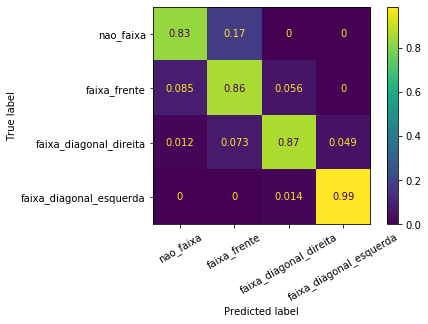

Rodada 1	-	Seed 1786
                         precision    recall  f1-score   support

              nao_faixa       0.89      0.81      0.85        84
           faixa_frente       0.71      0.82      0.76        66
 faixa_diagonal_direita       0.83      0.85      0.84        73
faixa_diagonal_esquerda       0.93      0.88      0.91        77

               accuracy                           0.84       300
              macro avg       0.84      0.84      0.84       300
           weighted avg       0.85      0.84      0.84       300



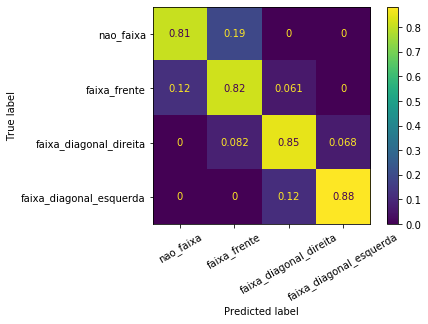

Rodada 2	-	Seed 775
                         precision    recall  f1-score   support

              nao_faixa       0.86      0.85      0.85        78
           faixa_frente       0.79      0.83      0.81        81
 faixa_diagonal_direita       0.82      0.85      0.83        71
faixa_diagonal_esquerda       0.94      0.87      0.90        70

               accuracy                           0.85       300
              macro avg       0.85      0.85      0.85       300
           weighted avg       0.85      0.85      0.85       300



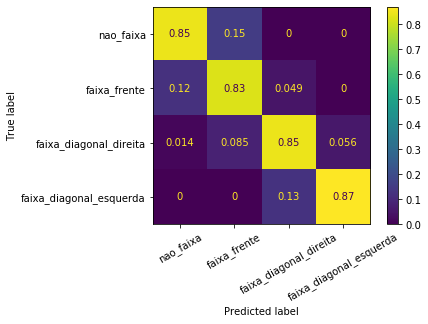

Rodada 3	-	Seed 7981
                         precision    recall  f1-score   support

              nao_faixa       0.85      0.87      0.86        89
           faixa_frente       0.71      0.74      0.72        76
 faixa_diagonal_direita       0.84      0.74      0.79        62
faixa_diagonal_esquerda       0.96      0.99      0.97        73

               accuracy                           0.84       300
              macro avg       0.84      0.83      0.83       300
           weighted avg       0.84      0.84      0.84       300



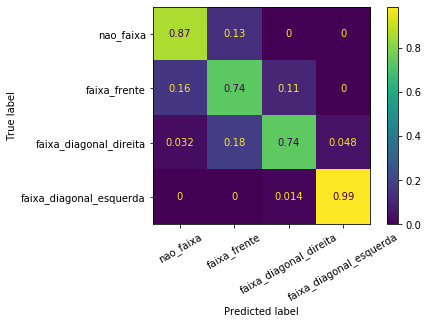

Rodada 4	-	Seed 3945
                         precision    recall  f1-score   support

              nao_faixa       0.84      0.86      0.85        73
           faixa_frente       0.81      0.80      0.81        82
 faixa_diagonal_direita       0.90      0.85      0.88        67
faixa_diagonal_esquerda       0.94      0.97      0.96        78

               accuracy                           0.87       300
              macro avg       0.87      0.87      0.87       300
           weighted avg       0.87      0.87      0.87       300



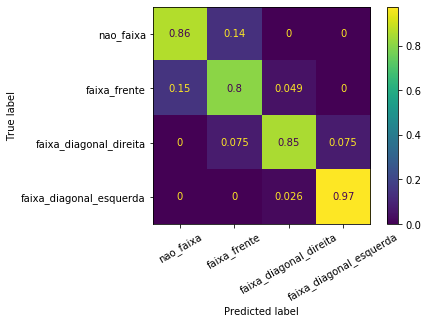

Rodada 5	-	Seed 5030
                         precision    recall  f1-score   support

              nao_faixa       0.85      0.82      0.83        82
           faixa_frente       0.69      0.78      0.73        77
 faixa_diagonal_direita       0.87      0.75      0.81        77
faixa_diagonal_esquerda       0.91      0.95      0.93        64

               accuracy                           0.82       300
              macro avg       0.83      0.83      0.83       300
           weighted avg       0.83      0.82      0.82       300



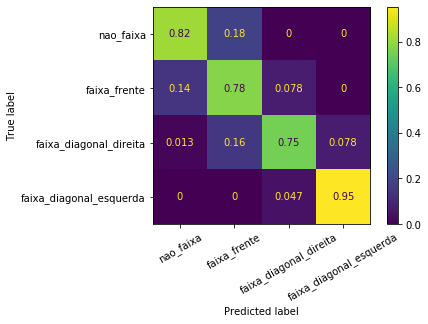

Rodada 6	-	Seed 3759
                         precision    recall  f1-score   support

              nao_faixa       0.76      0.94      0.84        67
           faixa_frente       0.73      0.69      0.71        70
 faixa_diagonal_direita       0.93      0.68      0.78        80
faixa_diagonal_esquerda       0.88      0.99      0.93        83

               accuracy                           0.82       300
              macro avg       0.82      0.82      0.82       300
           weighted avg       0.83      0.82      0.82       300



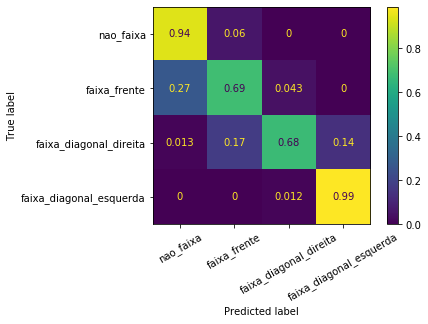

Rodada 7	-	Seed 4483
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.91      0.91        74
           faixa_frente       0.82      0.82      0.82        80
 faixa_diagonal_direita       0.81      0.86      0.83        73
faixa_diagonal_esquerda       0.96      0.89      0.92        73

               accuracy                           0.87       300
              macro avg       0.87      0.87      0.87       300
           weighted avg       0.87      0.87      0.87       300



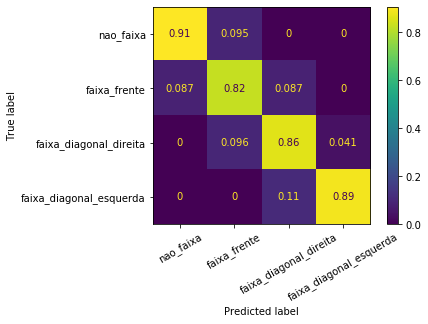

Rodada 8	-	Seed 2255
                         precision    recall  f1-score   support

              nao_faixa       0.84      0.90      0.87        72
           faixa_frente       0.86      0.82      0.84        85
 faixa_diagonal_direita       0.86      0.81      0.83        68
faixa_diagonal_esquerda       0.91      0.95      0.93        75

               accuracy                           0.87       300
              macro avg       0.87      0.87      0.87       300
           weighted avg       0.87      0.87      0.87       300



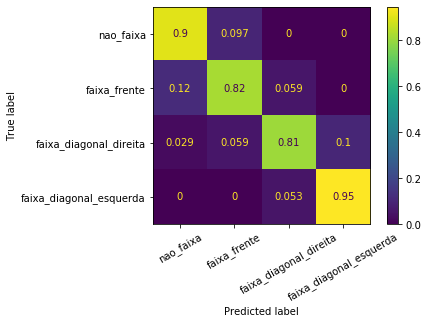

Rodada 9	-	Seed 2624
                         precision    recall  f1-score   support

              nao_faixa       0.89      0.88      0.88        83
           faixa_frente       0.80      0.85      0.83        78
 faixa_diagonal_direita       0.85      0.80      0.82        64
faixa_diagonal_esquerda       0.91      0.92      0.91        75

               accuracy                           0.86       300
              macro avg       0.86      0.86      0.86       300
           weighted avg       0.86      0.86      0.86       300



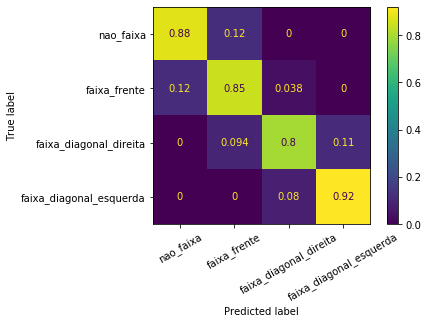

Rodada 10	-	Seed 263
                         precision    recall  f1-score   support

              nao_faixa       0.81      0.86      0.84        80
           faixa_frente       0.68      0.58      0.62        66
 faixa_diagonal_direita       0.62      0.83      0.71        60
faixa_diagonal_esquerda       0.97      0.82      0.89        94

               accuracy                           0.78       300
              macro avg       0.77      0.77      0.77       300
           weighted avg       0.80      0.78      0.78       300



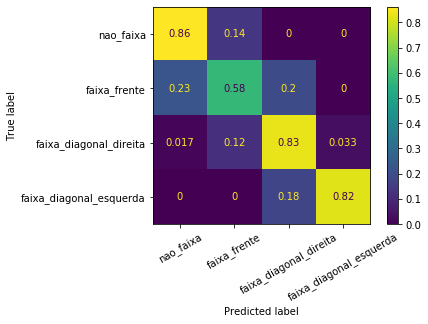

Rodada 11	-	Seed 7318
                         precision    recall  f1-score   support

              nao_faixa       0.94      0.90      0.92        82
           faixa_frente       0.77      0.88      0.82        66
 faixa_diagonal_direita       0.92      0.81      0.87        75
faixa_diagonal_esquerda       0.95      0.99      0.97        77

               accuracy                           0.90       300
              macro avg       0.90      0.90      0.89       300
           weighted avg       0.90      0.90      0.90       300



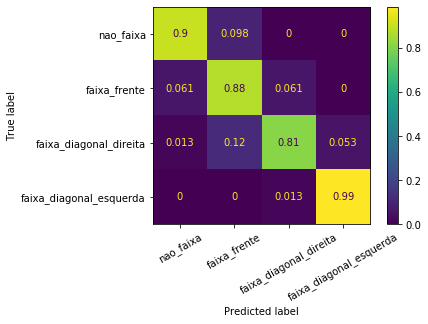

Rodada 12	-	Seed 7961
                         precision    recall  f1-score   support

              nao_faixa       0.88      0.83      0.86        78
           faixa_frente       0.78      0.86      0.82        79
 faixa_diagonal_direita       0.96      0.86      0.91        79
faixa_diagonal_esquerda       0.93      0.98      0.95        64

               accuracy                           0.88       300
              macro avg       0.89      0.88      0.88       300
           weighted avg       0.88      0.88      0.88       300



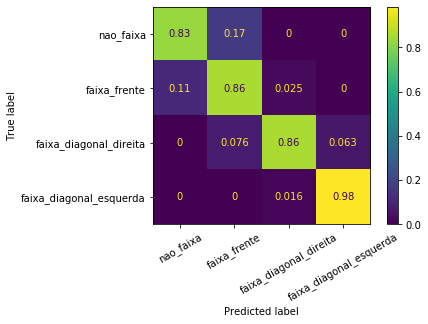

Rodada 13	-	Seed 7189
                         precision    recall  f1-score   support

              nao_faixa       0.88      0.82      0.85        83
           faixa_frente       0.75      0.77      0.76        69
 faixa_diagonal_direita       0.85      0.93      0.89        68
faixa_diagonal_esquerda       0.99      0.96      0.97        80

               accuracy                           0.87       300
              macro avg       0.87      0.87      0.87       300
           weighted avg       0.87      0.87      0.87       300



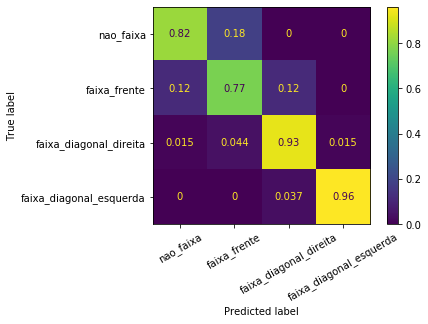

Rodada 14	-	Seed 2007
                         precision    recall  f1-score   support

              nao_faixa       0.89      0.85      0.87        84
           faixa_frente       0.70      0.81      0.75        70
 faixa_diagonal_direita       0.90      0.80      0.85        79
faixa_diagonal_esquerda       0.94      0.96      0.95        67

               accuracy                           0.85       300
              macro avg       0.86      0.85      0.85       300
           weighted avg       0.86      0.85      0.85       300



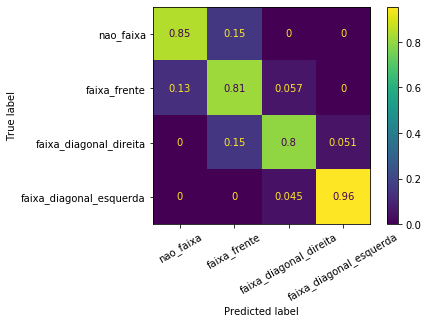

Rodada 15	-	Seed 7433
                         precision    recall  f1-score   support

              nao_faixa       0.85      0.82      0.84        68
           faixa_frente       0.78      0.82      0.79        76
 faixa_diagonal_direita       0.93      0.86      0.89        88
faixa_diagonal_esquerda       0.92      0.97      0.94        68

               accuracy                           0.87       300
              macro avg       0.87      0.87      0.87       300
           weighted avg       0.87      0.87      0.87       300



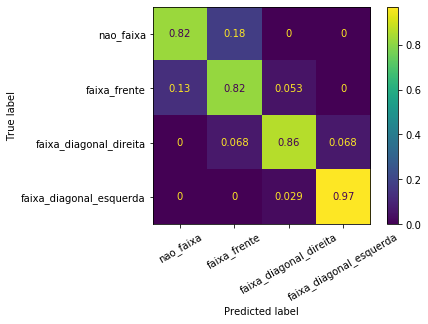

Rodada 16	-	Seed 5524
                         precision    recall  f1-score   support

              nao_faixa       0.87      0.90      0.88        77
           faixa_frente       0.75      0.81      0.78        67
 faixa_diagonal_direita       0.93      0.86      0.89        79
faixa_diagonal_esquerda       1.00      0.99      0.99        77

               accuracy                           0.89       300
              macro avg       0.89      0.89      0.89       300
           weighted avg       0.89      0.89      0.89       300



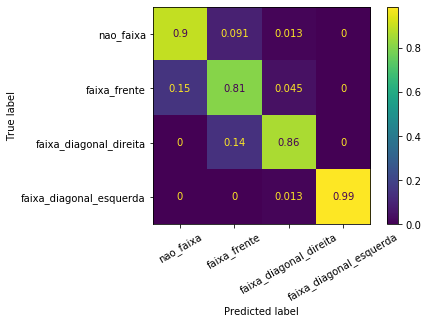

Rodada 17	-	Seed 958
                         precision    recall  f1-score   support

              nao_faixa       0.80      0.89      0.84        74
           faixa_frente       0.85      0.74      0.79        90
 faixa_diagonal_direita       0.80      0.88      0.84        68
faixa_diagonal_esquerda       0.97      0.90      0.93        68

               accuracy                           0.85       300
              macro avg       0.85      0.85      0.85       300
           weighted avg       0.85      0.85      0.85       300



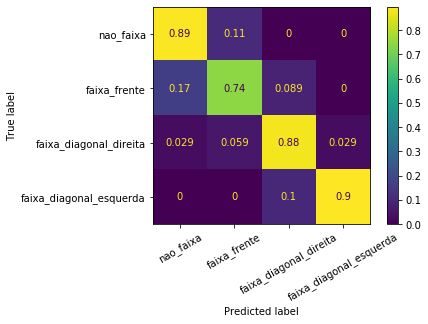

Rodada 18	-	Seed 265
                         precision    recall  f1-score   support

              nao_faixa       0.89      0.97      0.93        67
           faixa_frente       0.93      0.86      0.89        87
 faixa_diagonal_direita       0.88      0.89      0.88        72
faixa_diagonal_esquerda       0.95      0.93      0.94        74

               accuracy                           0.91       300
              macro avg       0.91      0.91      0.91       300
           weighted avg       0.91      0.91      0.91       300



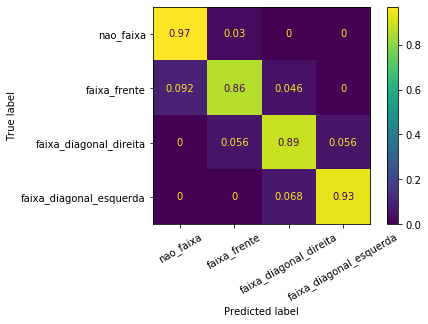

Rodada 19	-	Seed 6999
                         precision    recall  f1-score   support

              nao_faixa       0.91      0.84      0.87        73
           faixa_frente       0.77      0.91      0.83        75
 faixa_diagonal_direita       0.93      0.85      0.89        74
faixa_diagonal_esquerda       0.97      0.96      0.97        78

               accuracy                           0.89       300
              macro avg       0.90      0.89      0.89       300
           weighted avg       0.90      0.89      0.89       300



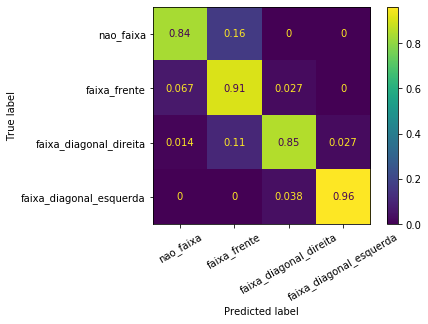

Rodada 20	-	Seed 4042
                         precision    recall  f1-score   support

              nao_faixa       0.86      0.96      0.91        67
           faixa_frente       0.84      0.87      0.85        83
 faixa_diagonal_direita       0.95      0.72      0.82        81
faixa_diagonal_esquerda       0.86      0.99      0.92        69

               accuracy                           0.87       300
              macro avg       0.88      0.88      0.87       300
           weighted avg       0.88      0.87      0.87       300



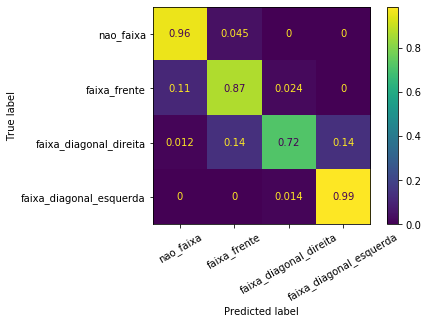

Rodada 21	-	Seed 602
                         precision    recall  f1-score   support

              nao_faixa       0.81      0.80      0.80        79
           faixa_frente       0.73      0.80      0.77        76
 faixa_diagonal_direita       0.92      0.87      0.89        75
faixa_diagonal_esquerda       0.97      0.94      0.96        70

               accuracy                           0.85       300
              macro avg       0.86      0.85      0.85       300
           weighted avg       0.85      0.85      0.85       300



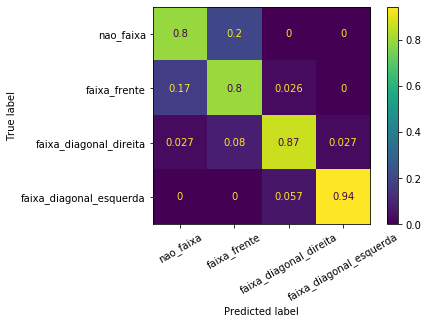

Rodada 22	-	Seed 2672
                         precision    recall  f1-score   support

              nao_faixa       0.89      0.83      0.86        76
           faixa_frente       0.74      0.78      0.76        67
 faixa_diagonal_direita       0.76      0.90      0.82        68
faixa_diagonal_esquerda       0.97      0.87      0.92        89

               accuracy                           0.84       300
              macro avg       0.84      0.84      0.84       300
           weighted avg       0.85      0.84      0.85       300



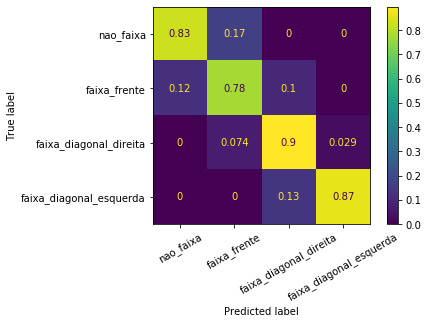

Rodada 23	-	Seed 6259
                         precision    recall  f1-score   support

              nao_faixa       0.93      0.78      0.85        79
           faixa_frente       0.72      0.90      0.80        77
 faixa_diagonal_direita       0.90      0.82      0.86        77
faixa_diagonal_esquerda       0.96      0.96      0.96        67

               accuracy                           0.86       300
              macro avg       0.87      0.86      0.86       300
           weighted avg       0.87      0.86      0.86       300



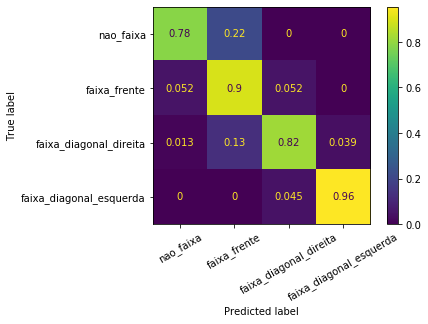

Rodada 24	-	Seed 244
                         precision    recall  f1-score   support

              nao_faixa       0.86      0.86      0.86        84
           faixa_frente       0.79      0.83      0.81        75
 faixa_diagonal_direita       0.94      0.85      0.89        78
faixa_diagonal_esquerda       0.90      0.97      0.93        63

               accuracy                           0.87       300
              macro avg       0.87      0.87      0.87       300
           weighted avg       0.87      0.87      0.87       300



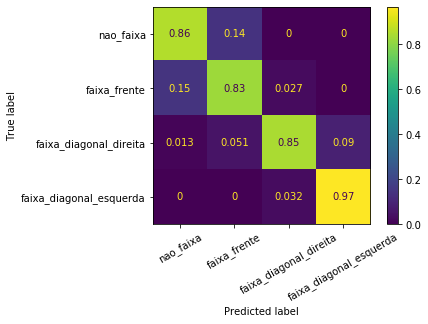

Rodada 25	-	Seed 7776
                         precision    recall  f1-score   support

              nao_faixa       0.81      0.93      0.86        55
           faixa_frente       0.77      0.81      0.79        80
 faixa_diagonal_direita       0.89      0.72      0.80        87
faixa_diagonal_esquerda       0.90      0.95      0.92        78

               accuracy                           0.84       300
              macro avg       0.84      0.85      0.84       300
           weighted avg       0.85      0.84      0.84       300



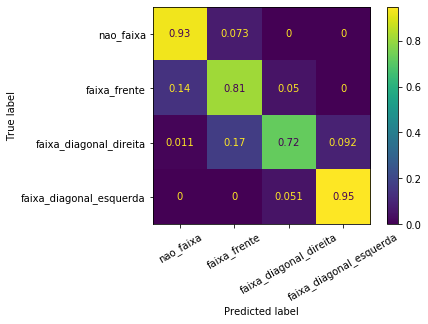

Rodada 26	-	Seed 3211
                         precision    recall  f1-score   support

              nao_faixa       0.80      0.76      0.78        67
           faixa_frente       0.69      0.82      0.75        71
 faixa_diagonal_direita       0.96      0.83      0.89        83
faixa_diagonal_esquerda       0.96      0.97      0.97        79

               accuracy                           0.85       300
              macro avg       0.85      0.85      0.85       300
           weighted avg       0.86      0.85      0.85       300



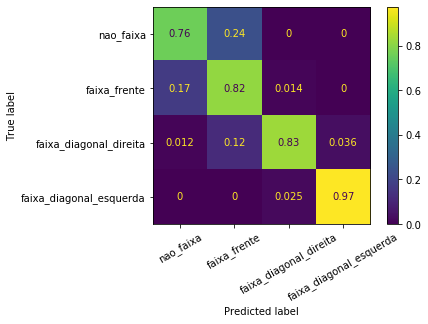

Rodada 27	-	Seed 3373
                         precision    recall  f1-score   support

              nao_faixa       0.87      0.88      0.87        74
           faixa_frente       0.84      0.84      0.84        92
 faixa_diagonal_direita       0.85      0.88      0.86        72
faixa_diagonal_esquerda       0.95      0.90      0.93        62

               accuracy                           0.87       300
              macro avg       0.88      0.87      0.87       300
           weighted avg       0.87      0.87      0.87       300



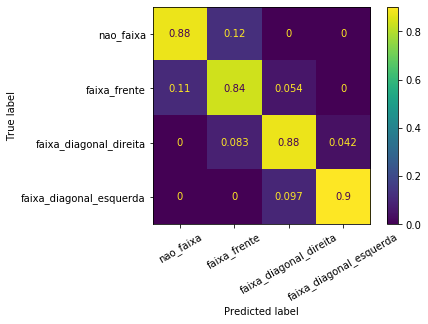

Rodada 28	-	Seed 3952
                         precision    recall  f1-score   support

              nao_faixa       0.85      0.82      0.84        78
           faixa_frente       0.73      0.83      0.78        69
 faixa_diagonal_direita       0.91      0.83      0.87        72
faixa_diagonal_esquerda       0.96      0.96      0.96        81

               accuracy                           0.86       300
              macro avg       0.86      0.86      0.86       300
           weighted avg       0.87      0.86      0.86       300



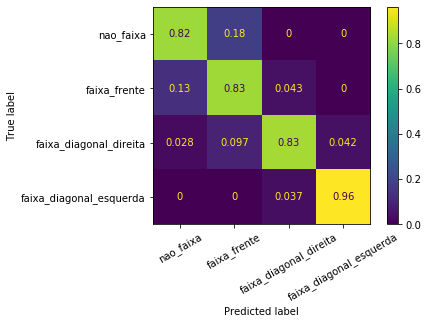

Rodada 29	-	Seed 4128
                         precision    recall  f1-score   support

              nao_faixa       0.90      0.88      0.89        75
           faixa_frente       0.81      0.86      0.83        84
 faixa_diagonal_direita       0.87      0.85      0.86        72
faixa_diagonal_esquerda       0.96      0.94      0.95        69

               accuracy                           0.88       300
              macro avg       0.89      0.88      0.88       300
           weighted avg       0.88      0.88      0.88       300



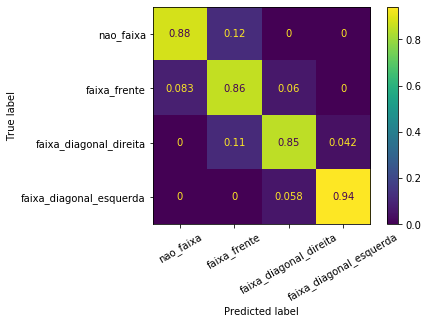

In [6]:
df = pd.read_csv('./csvs/otsu_sup-lbp_faixas.csv').tail(1000)
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

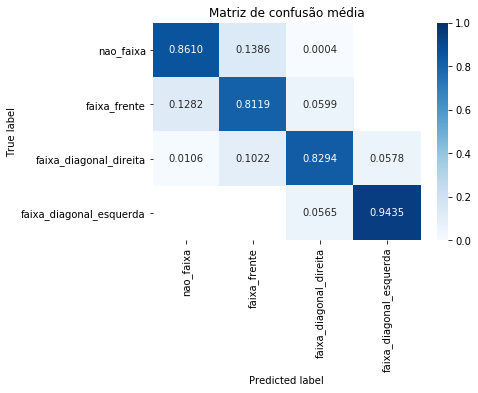

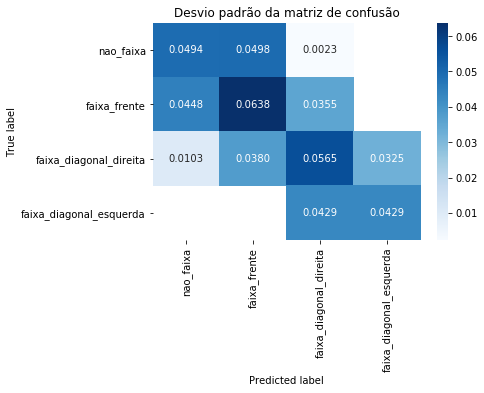

In [7]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-nao_faixa  f1-faixa_frente  f1-faixa_diagonal_direita  \
count  30.000000     30.000000        30.000000                  30.000000   
mean    0.860333      0.860415         0.789189                   0.849637   
std     0.025870      0.031606         0.052254                   0.043702   
min     0.780000      0.778626         0.622951                   0.714286   
25%     0.846667      0.842902         0.759484                   0.826577   
50%     0.865000      0.856349         0.796280                   0.858149   
75%     0.873333      0.872483         0.824424                   0.887324   
max     0.910000      0.928571         0.892857                   0.906667   

       f1-faixa_diagonal_esquerda  
count                   30.000000  
mean                     0.941715  
std                      0.024576  
min                      0.890173  
25%                      0.925155  
50%                      0.940816  
75%                      0.961353  
max      

Acurácia,f1-nao_faixa,f1-faixa_frente,f1-faixa_diagonal_direita,f1-faixa_diagonal_esquerda
0.883333,0.863014,0.807947,0.898734,0.965517
0.840000,0.850000,0.760563,0.837838,0.906667
0.846667,0.851613,0.807229,0.833333,0.903704
0.836667,0.855556,0.722581,0.786325,0.972973
0.873333,0.851351,0.809816,0.876923,0.955975
0.820000,0.832298,0.731707,0.805556,0.931298
0.823333,0.840000,0.705882,0.782609,0.931818
0.870000,0.905405,0.825000,0.834437,0.921986
0.870000,0.872483,0.843373,0.833333,0.928105
0.863333,0.884848,0.825000,0.822581,0.913907


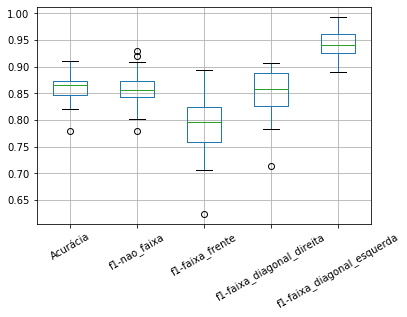

In [8]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')